[0.64337632 0.44953692 0.52759856 0.0975202  0.06112368]
The best pair is ( 0 , 2 ) with reward 0.83


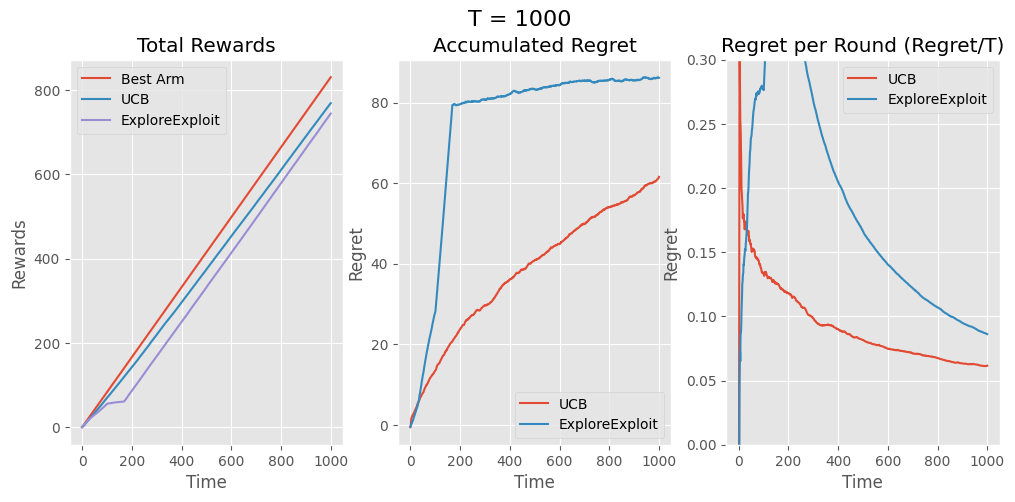

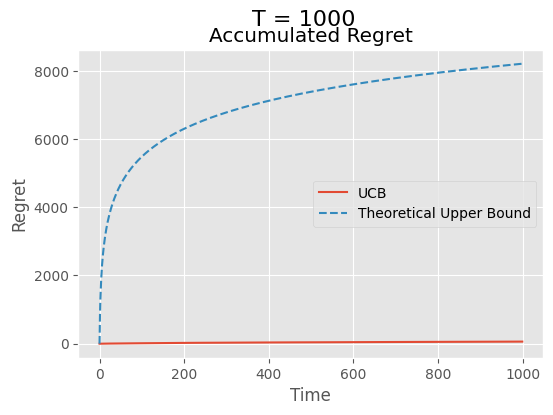

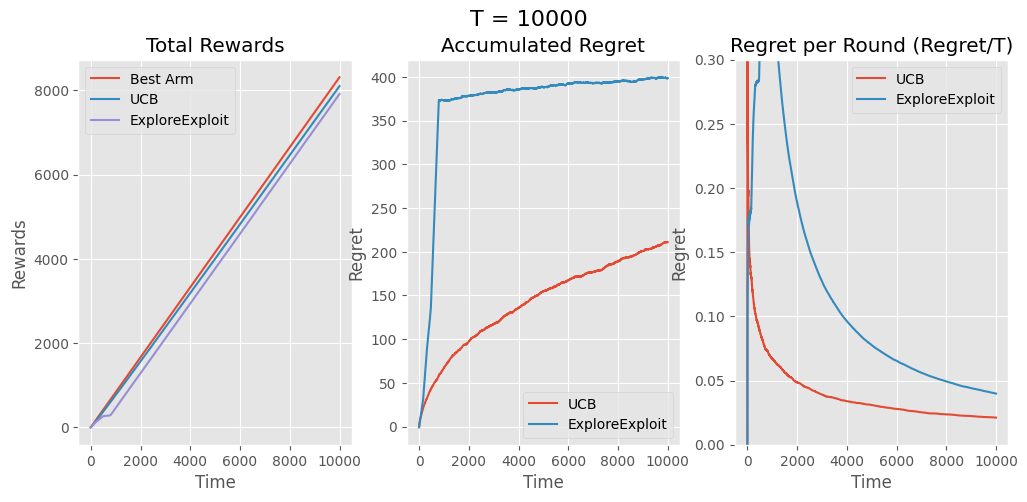

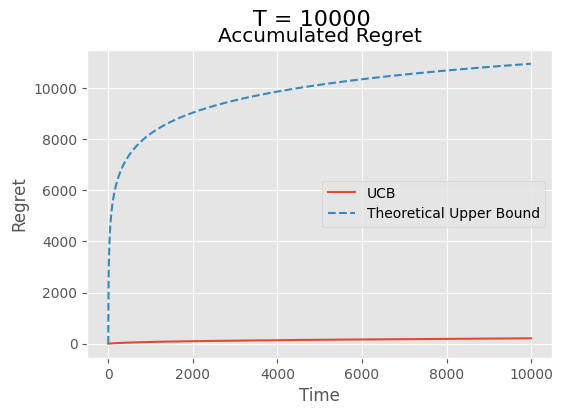

In [1]:

# Reinforcement Learning and Dynamic Optimization
# Assignment 1: Recommending Pairs of News Stories using Bandits

# Problem Context
# Display a pair of articles (i,j), where i is the top article and j is the bottom.
# The user clicks either i (with probability pi​) or j (with probability (1−pi)*pj, but not both.
# Goal: Learn which pairs (i,j) maximize the expected reward μ(i,j)=pi+(1−pi)pj​.


# Lamprakis Michalis 2020030077.    (10/3/2025)

#-------------------Subtask 1---------------------#
# Implementation of an Explore & Exploit Algorithm and a UCB for this problem.

# import libraries and set plotting style.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

np.random.seed(77) # my AM 2020030077
style.use('ggplot')

# ENV Variables and Initialize True and Estimated Arm Means

K = 5                                      #  K = 5 "Fresh" news articles  to choose from
arm_true = np.random.uniform(0.0,0.7,5)    # Create K ``Bernoulli'' arms with mean reward drawn uniformly in [0.2,0.7]
print(arm_true)                            # Bernoulli: Arm i will give reward 1 with probability arm_true[i], and 0 otherwise

# So in our set up we need to calculate μ(i,j)* as the optimal reward.
# μ(i,j)=pi+(1−pi)pj

best_pair_reward = 0  # The higher pair reward.
best_i, best_j = 0, 0 # The optimal pair (i,j)
for i in range(K):
    for j in range(K):
        if i != j:
            current_reward = arm_true[i] + (1 - arm_true[i]) * arm_true[j] # Calculate the reward of each pair
            if current_reward > best_pair_reward:                          # Find the maximum reward iterative.
                best_pair_reward = current_reward
                best_i, best_j = i, j      # index of the optimal pair

print("The best pair is (",best_i,",", best_j,") with reward", round(best_pair_reward,2))


# Run for different horizons. T=1000 and T=10000
t=[1000,10000] # Horizon
for T in t:

  N = np.power(T / K, 2 / 3).astype(int)   # This achieves sublinear regret O(T^(2/3))


  #------------------Explore Then Exploit----------------------#
  # Implementation of Explor Then Exploit Aglorithm.
  r_total_ex = np.zeros(T)  # This will store the total accumulated rewards.
  epochs = 50               # Number of experiments. Need to run a lot of experiments so as to have the expected results.
                            # Sometimes the algorithm will pick the correct arm sometimes. (In our case "articles")

  for e in range(epochs):

    # Exploration period N*K
    arm_est = np.zeros(K)         # Store the estimated (mean) click probability of each article.
    r_explore = np.zeros([K, N])  # Store exploration results of each arm. Each arm K has been played for N rounds thats why KxN.
    r_exploit = np.zeros(T - N*K)

    # Explore each arm equally for N rounds
    for i in range(K):
      r_explore[i] = np.random.binomial(1,p = arm_true[i], size=N)  # Simulate clicks. Do N Bernoulli experiments with probability μ_i(the probability of each arm arm_true)

      arm_est[i] = np.mean(r_explore[i])                            # Estimate the mean reward \hat{μ_i} from the exploration period

    best_two = np.argsort(arm_est)[-2:]  # Sort arm_est and pick the last 2 of the array. The arms with the 2 highest probability.
                                         # So best_two[1] contains the index of the arm with the highest estimated click probability
                                         # and  best_two[0] the index of the arm with the second highest.

    # Exploitation. Exploitation period T - N*K

    # The concept here is that one article is on the top of the page and the other on the bottom.
    # The one with the highest click probability is placed on the top.
    # There can be at most one click (per user), either for article best_two[0] or for article best_two[1].

    # So, for the exploitation period.
    for t in range(T - N*K):

      click_top = np.random.binomial(1, p=arm_true[best_two[1]])      # Calculate the reward of the top article (Click or not) with probability pi. So click_top = 0 or 1.

      if click_top == 0:                                              # If click_top = 0, the user hasn't clicked top placed article and moves to the bottom one
        click_bottom = np.random.binomial(1, p=arm_true[best_two[0]]) # and calculate the reward (click or not) with probability pj.
      else:
        click_bottom = 0                                              # if click_top = 1 means that the user clicked the top article so set click_bottom = 0.
                                                                      # (to ensure only one article is clicked per round)

      r_exploit[t] = click_top + click_bottom                         # So r_exploit per round is 0 or 1.

    r_explore = r_explore.flatten()                     # Reward in explore round are array of [K,N] --> "flatten" into a vector of size KxN
    r_per_slot = np.concatenate([r_explore,r_exploit])  # Add together in one vector rewards during Explore and during Exploit

    r_total_ex += r_per_slot.cumsum()                   # Compute the cumulative sum of rewards over time (T).
                                                        # This creates an array of size T where each element stores
                                                        # the total accumulated reward up to that time step.
                                                        # This helps track the progression of the total reward.

  r_avg_tot_ex = r_total_ex/epochs                      #This just averages accumulated rewards over all epochs/experiments



  #------------------Upper Confidence Bound----------------------#
  # Implementation of UCB Aglorithm.

  r_total_ucb = np.zeros(T)    # This will store the total accumulated rewards.
  epochs = 50                  # Number of experiments. Need to run a lot of experiments so as to have the expected results.
                               # Sometimes the algorithm will pick the correct arm sometimes. (In our case "articles")

  for e in range(epochs):
      arm_count = np.zeros(K)  # Number of times each arm was played
      arm_est = np.zeros(K)    # Estimated (mean) click probability of each article. This changes as the game keeps going.
      r_ucb = np.zeros(T)      # Store rewards at each time step



      # Play each arm once (Initialization)
      for i in range(K):
          cur_reward = np.random.binomial(1, arm_true[i])  # Simulate a click
          arm_est[i] = cur_reward
          arm_count[i] = 1
          r_ucb[i] = cur_reward



      # UCB
      for t in range(K, T):
          ucb_values = arm_est + np.sqrt(2 * np.log(t) / (arm_count))  # UCB formula.


          # Select top 2 articles
          best_two = np.argsort(ucb_values)[-2:]  # Sort ucb_values and pick the last 2 of the array. The arms with the 2 highest upper confidence bounds.
                                                  # So best_two[1] contains the index of the arm with the highest ucb
                                                  # and  best_two[0] the index of the arm with the second highest.

          # Exaclty the same as before.
          click_top = np.random.binomial(1, p=arm_true[best_two[1]])
          if click_top == 0:
            click_bottom = np.random.binomial(1, p=arm_true[best_two[0]])
          else:
            click_bottom = 0

          reward = click_top + click_bottom       # reward at this round (1 or 0).

          # So here when pair (i,j) is played, update statistics for both i and j based on the observed reward.
          # Why? Simply because the reward depends on both arms in the pair. In the end only one is clicked but the result (1 or 0) is influenced by their joint configuration.

          arm_count[best_two[1]] += 1                                                      # Update arm counter of the chosen pair.
          arm_count[best_two[0]] += 1
          arm_est[best_two[1]] += (reward - arm_est[best_two[1]]) / arm_count[best_two[1]] # Formula of calculating the mean reward \hat{μ_i}, \hat{μ_j}  of the chosen article pair so far.
          arm_est[best_two[0]] += (reward - arm_est[best_two[0]]) / arm_count[best_two[0]] # In the report i have proven the formula i use.
          r_ucb[t] = reward                                                                # Store the reward.

      r_total_ucb += r_ucb.cumsum()     # Compute the cumulative sum of rewards over time (T).
                                        # This creates an array of size T where each element stores
                                        # the total accumulated reward up to that time step.
                                        # This helps track the progression of the total reward.

  r_avg_tot_ucb = r_total_ucb / epochs  # Average over multiple epochs.

  #----PLOT----#

  # The following just plots:
  # (left) total rewards of Best Arm (theoretical) ,total rewards of Explore and Exploit and total rewards of UCB.
  # (middle) Expected (total) Regret over time (Explore Exploit and UCB).
  # (right) Expeced Regret per round (Explore Exploit and UCB).

  fig, ax = plt.subplots(1, 3, figsize=(12, 5))
  fig.suptitle(f"T = {T}", fontsize=16)
  x = np.arange(T)

  best = x * best_pair_reward  # Maximum possible reward. The reward we get if we display only the optimal pair. best_pair_reward = μ(i,j)*.

  # Total Reward
  ax[0].plot(x, best, label='Best Arm')
  ax[0].plot(x, r_avg_tot_ucb, label='UCB')
  ax[0].plot(x, r_avg_tot_ex, label='ExploreExploit')
  ax[0].set_xlabel('Time')
  ax[0].set_ylabel('Rewards')
  ax[0].set_title('Total Rewards')
  ax[0].legend()

  # Accumulated Regret
  ax[1].plot(x, best - r_avg_tot_ucb,label='UCB')
  ax[1].plot(x, best - r_avg_tot_ex, label='ExploreExploit')
  ax[1].set_xlabel('Time')
  ax[1].set_ylabel('Regret')
  ax[1].set_title('Accumulated Regret')
  ax[1].legend()


  # Regret per Round
  ax[2].plot(x, (best - r_avg_tot_ucb) / (x + 1), label='UCB')
  ax[2].plot(x, (best - r_avg_tot_ex) / (x + 1), label='ExploreExploit')
  ax[2].set_xlabel('Time')
  ax[2].set_ylabel('Regret')
  ax[2].set_title('Regret per Round (Regret/T)')
  ax[2].set_ylim(0, 0.3)
  ax[2].legend()

  plt.show()

  #-------------------Subtask 3---------------------#
  # In this subtask i will calculate the (instance-dependent) theoretical regret of UCB for this problem, and
  # demonstrate that the achieved regret for my UCB implementation is indeed upper-bounded by the theoretical curve.

  # *The detailed proof of this formula is provided in my report.

  true_reward = np.zeros([K, K])    # Stores true reward of each pair μ(i,j).
  theoretical_bound = np.zeros(T)   # Stores the theoretical bound at each time step.


  # Calculate μ(i,j)=pi+(1−pi)pj for each pair.
  for i in range(K):
    for j in range(K):
      if i != j:
          true_reward[i][j] = arm_true[i] + (1-arm_true[i])*arm_true[j]

  # Calculate theoretical bound (with the proven formula).
  for t in range(T):
    for i in range(K):
      for j in range(K):
        if i != j:
            denοm = best_pair_reward - true_reward[i][j]                  # Calculate the denominator of the formula and ensure that
            if denοm != 0:                                                # there is no division with zero. (e.g the optimal pair's denom = 0, ignore it).
              theoretical_bound[t] += (8 * np.log(t + 1)) / denοm



  fig, ax = plt.subplots(figsize=(6, 4))
  fig.suptitle(f"T = {T}", fontsize=16)
  x = np.arange(T)

  # Accumulated Regret
  ax.plot(x, best - r_avg_tot_ucb, label='UCB')
  ax.plot(x, theoretical_bound, label='Theoretical Upper Bound', linestyle='--')  # Add this line
  ax.set_xlabel('Time')
  ax.set_ylabel('Regret')
  ax.set_title('Accumulated Regret')

  ax.legend()

  plt.show()
